In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np 
from tqdm.auto import tqdm,trange
import multiprocessing


In [2]:
class Environment():
    def __init__(self, arms: int, starts = None, non_stationary: bool = False):
        self.arms = arms
        self.means = np.zeros(arms,float) if starts is None else starts
        self.non_stationary = non_stationary
        self.optimal_over_time = []

    def step(self, action: int):
        reward = np.random.normal(self.means[action],1.0)

        self.optimal_over_time.append(1 if action in self.optimal_action() else 0)

        if self.non_stationary: self.means += np.random.normal(0,0.01,arms)

        return reward

    def optimal_action(self):
        return np.argwhere(self.means == np.amax(self.means)).flatten().tolist()

    def get_optimal_over_time(self):
        return self.optimal_over_time

In [3]:
class Value_Function():
    def __init__(self, arms: int):
        self.Qs = np.zeros(arms,float)
        self.visit_ns = np.ones(arms,int)
    
    def update(self, arm: int, reward: float, alpha: float):
        self.Qs[arm] = self.Qs[arm] + alpha * (reward - self.Qs[arm])
        self.visit_ns[arm] += 1

    def get_values(self):
        return self.Qs

    def get_visits(self,arm):
        return self.visit_ns[arm]

In [4]:
def get_action(arms: int, epsilon: float, value_function: Value_Function):
    if np.random.uniform(0,1.0,1) < epsilon:
        return np.random.choice(range(arms))
    else:
        values = value_function.get_values()
        return np.random.choice([action_ for action_,value_ in enumerate(values) if value_ == np.max(values)])

In [5]:
def generate_starts(arms):
    return np.random.normal(0,1,arms)

In [6]:
def alpha_generator(initial_alpha, value_n, alpha_type = "constant"):
    if alpha_type == "constant":
        return initial_alpha
    if alpha_type == "sample":
        return 1/value_n
    else:
        return 0.1

In [7]:
# runs = 10
# steps = 10_000_000
# epsilon = 0.1
# arms = 10
# alpha = 0.1
# starts = [0.2,-0.8,1.8,0.5,1.5,-1.3,-0.1,-1.0,0.7,-0.7]

# optimal_lines = []
# for _ in tqdm(range(runs)):
#     environment = Environment(arms, None, True)
#     value_function = Value_Function(arms)
#     for _ in range(steps):
#         action = get_action(arms, epsilon, value_function)
#         reward = environment.step(action)
#         value_function.update(action, reward, alpha)
#     optimal_lines.append(environment.get_optimal_over_time())
# optimals = np.mean(optimal_lines, axis = 0)

# plt.figure(figsize=(10,10))
# plt.axhline(y=0.8, color = 'orange', linestyle='--')
# plt.plot(optimals)
# plt.title("Percent Optimal Arm Chosen with Arm Random Mean Walks from 0 with Epsilon = 0.2")
# plt.ylabel("Cumulative Percent Optimal at Step")
# plt.xlabel("Step")
# plt.ylim(0,1.0)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
# plt.savefig("../figures/exercise2-5/Percent_Optimal_Arm_Chosen_with_Arm_Random_Mean_walks_from_0_with_Epsilon_=_02.png")

In [10]:
runs = 200
steps = int(1e3)
arms = 10
initial_alpha = 0.1
# alphas = ["constant","constant","constant","sample","sample","sample"]
# epsilons = [0.0,0.1,0.01,0.0,0.1,0.01]
alphas = ["sample","sample","sample"]
epsilons = [0.0,0.1,0.01]

optimal_lines = []
for alphaChoice, epsilon in zip(alphas,epsilons):
    optimal_over_time_all_runs = []
    for _ in tqdm(range(runs)):
        starts = generate_starts(arms)
        environment = Environment(arms, starts, False)
        value_function = Value_Function(arms)
        for step in range(steps):
            action = get_action(arms, epsilon, value_function)
            reward = environment.step(action)
            alpha = alpha_generator(initial_alpha, value_function.get_visits(action), alphaChoice)
            value_function.update(action, reward, alpha)
        optimal_over_time_all_runs.append(environment.get_optimal_over_time())
    optimal_lines.append(np.mean(optimal_over_time_all_runs, axis = 0))

631  1.11888307 -0.46512541  0.00574109
  0.57899293  1.31708611  0.45211259 -0.35830855]
 30%|███       | 60/200 [00:04<00:10, 13.15it/s][ 1.09558531 -1.30650118  0.33802956  0.3045812  -1.64351117  0.83627729
 -0.55620249  0.02536163  0.72559144  0.06089864]
[-0.12893714  1.12423834 -0.15820431  0.05081579  1.70275039 -0.48697733
  1.41905975  1.10873374 -0.06632132 -0.37047554]
[ 0.00155957  0.1342596   0.90810828 -0.35043913 -0.26497887 -0.35867587
  0.99659445 -1.18716094 -1.20466734 -0.73942596]
 32%|███▏      | 64/200 [00:04<00:10, 13.36it/s][ 0.61638852 -0.41589635 -0.34171322 -0.55270349 -0.13053155 -0.34109738
  0.66664514  0.503065   -0.42084592  1.88695622]
[ 1.59637066  0.13197716 -0.59675293 -1.78340322 -0.72872427 -0.00248637
  1.2554224   0.47153532 -0.19995217  0.11807281]
[ 9.00346951e-01  2.05797649e+00 -8.96064250e-01 -3.94031930e-01
  1.43667975e+00 -1.10931028e-03 -2.35752000e+00 -1.42554943e+00
 -2.90129640e-01  1.04589376e+00]
[ 0.89009783 -1.87291426 -1.3522887

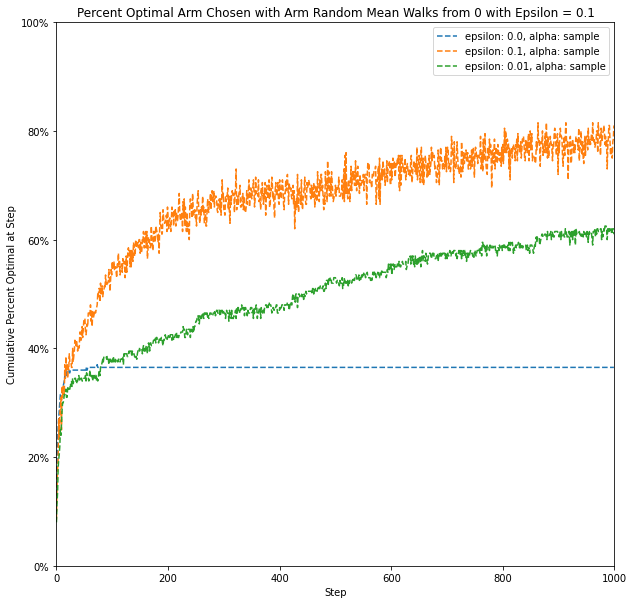

In [11]:
plt.figure(figsize=(10,10))
for optimals_i, optimals in enumerate(optimal_lines):
    plt.plot(optimals, label = "epsilon: " + str(epsilons[optimals_i]) + ", alpha: " + alphas[optimals_i], linestyle = "--" if alphas[optimals_i] == "sample" else "-")
plt.title("Percent Optimal Arm Chosen with Arm Random Mean Walks from 0 with Epsilon = 0.1")
plt.ylabel("Cumulative Percent Optimal at Step")
plt.xlabel("Step")
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()